 **Approach and Tasks :**



1.   Set up the data preparation and computing the Fitness function
2.   Implement different algorithms to solve the problem  
3. Make nice graphs for evaluation and comparison between different approaches





   








# Part 1: Handling the data and computing fitness function
If your code doesn't work, you need to add the files to the left <-- , then it works, files are now in the folder Stocks_Data.

In [ ]:
import numpy as np
import random
import pandas as pd
from math import *
import matplotlib.pyplot as plt
from functools import reduce
from array import array
from mpmath import *

plt.rcParams["figure.figsize"] = (12, 8)

In [ ]:
# preparing data
files=['hdfc.csv','itc.csv','l_t.csv','m_m.csv','sunpha.csv','tcs.csv']
dfs=[]

for file in files:
    temp=pd.read_csv(file)
    temp.columns=['Date',file.replace('.csv','')]
    dfs.append(temp)

stocks = reduce(lambda left,right: pd.merge(left,right,on='Date'), dfs)

In [ ]:
# computing data
def hist_return(months):
    ''' It calculates Stock returns for various months and returns a dataframe.
        Input: Months in the form of a list.
        Output: Historical returns in the form of a DataFrame. '''
    idx=[]
    df=pd.DataFrame()
    for mon in months:
        temp=(stocks.iloc[0,1:] - stocks.iloc[mon,1:])/(stocks.iloc[mon,1:])
        idx.append(str(mon)+'_mon_return')
        df=pd.concat([df, temp.to_frame().T], ignore_index=True)
    df.index=idx
    return df  

hist_stock_returns=hist_return([3,6,12,24,36])

calculating Fitness function:

In [ ]:
# Convert to numeric columns from Object datatypes.
cols=hist_stock_returns.columns
hist_stock_returns[cols] = hist_stock_returns[cols].apply(pd.to_numeric, errors='coerce')
cov_hist_return=hist_stock_returns.cov()

# For ease of calculations make covariance of same variable as zero.
for i in range(6):
    cov_hist_return.iloc[i][i]=0
    
mean_hist_return=hist_stock_returns.mean()
sd_hist_return=hist_stock_returns.std()

def mean_portfolio_return(child):
    return np.sum(np.multiply(child,mean_hist_return))

def var_portfolio_return(child):
    part_1 = np.sum(np.multiply(child,sd_hist_return)**2)
    temp_lst=[]
    for i in range(6):
        for j in range(6):
            temp=cov_hist_return.iloc[i][j] * child[i] * child[j]
            temp_lst.append(temp)
    part_2=np.sum(temp_lst)
    return part_1+part_2

rf= 0.0697 #risk free factor

def fitness_function(child):
    return (mean_portfolio_return(child)-0.0697)/np.sqrt(var_portfolio_return(child))

To this point the code was from github with a bit of adjustments. Source: [here](https://github.com/naresh-dscience/Portfolio-Optimization-using-Genetic-Algorithm )

Now we can work with Fitness function aka Sharpe ratio, but first we will make portfolio generator:

In [ ]:
def normalize_sample(sample):
    ''' Function for normalizing values in array to sum=1, maintains the ratio
        Input: 1D array
        Output: normalized 1D array ''' 
    sum = np.sum(sample)
    for i in range(len(sample)):
        sample[i] = sample[i]/sum
    sample[0] +=  1 - np.sum(sample)

    return sample

def random_sample_generator(n):
    ''' Function for generating sample distributions into assets
        Input: int, scalar as a number of wanted assets
        Output: 1D array, with n scalars inside, sum of all is 1'''
    sample = []
    for i in range(n):
        tmp = np.random.rand()  
        sample.append(tmp)
    
    return normalize_sample(sample)

print(random_sample_generator(6))

[0.21927258651242612, 0.11690815386865179, 0.08592963845456562, 0.1418967688536549, 0.18381909873805233, 0.2521737535726491]


In [ ]:
best_sample = [0, 0.29, 0, 0, 0.23, 0.48] #~best so far
print(best_sample)
print(fitness_function(best_sample))

test_sample = random_sample_generator(6)

print(test_sample)
print(fitness_function(test_sample))

[0, 0.29, 0, 0, 0.23, 0.48]
6.142040377415357
[0.06952473245190749, 0.22332255470477366, 0.1415848316885148, 0.19986852076110295, 0.21946431918343567, 0.1462350412102654]
2.04429342282298


Main problem to decide: how to select neighbours. We have 6 double values, so there are many possibilities. How big should be the step, which and how many neigbours to choose?

So we can have a threshold (or let's say size of step), which will be reduced over time and we will change just two values of assets at time (one will decrease, the another will increase to maintain the sum)

In [ ]:
def fulfill_2d_list_for_plot(a):
    ''' Makes 2d array rectangular, filled numbers have the same value as the last number in a row '''
    max_len = len(max(a, key=len))
    for i in a:
        i += [i[len(i)-1]] * (max_len - len(i))
    return a

def plot_multiple_samples(a):
    ''' Plots from 2d array '''
    max_len = len(max(a, key=len))
    for i in a:
        plt.plot(np.arange(max_len), i)

top: 5.679698317889793 [7.001709802375683e-05, 0.2791800220388273, 1.5051361983177964e-05, 2.031759454093629e-05, 0.20014877006350473, 0.5205658218431201] final stepsize: 0.12145735523422346 number of steps 100
top: 3.689769915871059 [0.007804301280567999, 0.16761583757995777, 8.37299621193166e-11, 1.1238291020784195e-07, 9.191332268070944e-08, 0.8245796567595114] final stepsize: 0.0733924832860316 number of steps 201
top: 2.9956063326422453 [0.075650221254318, 0.21787686647946788, 3.5538574230343036e-07, 5.75110319699887e-07, 7.122373486211632e-07, 0.7064712695328035] final stepsize: 0.0733924832860316 number of steps 201
top: 1.5094553495483314 [0.2988670082266785, 0.2911323483554363, 0.0006240546046494321, 4.584343214448638e-06, 9.296301482693127e-06, 0.4093627081685387] final stepsize: 0.0733924832860316 number of steps 201
top: 3.738784588273036 [0.0012369693464182447, 0.16122845850423162, 2.3161075635503687e-06, 2.0346480610648054e-06, 1.5627890805509997e-06, 0.837528658604645] f

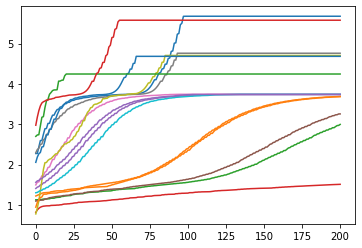

In [ ]:
fit_func_hist_cumulated = []

def hill_clibming_first_accept(start_state, step_size, reduce_step_size, n):
    ''' Function implementing Local search algorithm with first accept approach
        Input: 1D array, with n scalars inside, random numbers, sum is 1,
               float - initial size of step, (0.1 default)
               float - constant for reducing a step, should be sth (1,2> 
               int - number of assets in a portfolio (6 default)
        Output: 1D array, which Fitness function is better ~'''
    
    end = False
    present_state = start_state[:] # be careful to not making a reference instead of copy
    next_state = start_state[:]
    cnt = 0
    fitness_func_history = []
    while(not end):
        # print(step_size, fitness_function(present_state), present_state)
        end = True
        for i in range(n):
            for j in range(n-1):
                if i == j:
                    j += 1
                next_state[i] = present_state[i]*(1 + step_size)
                next_state[j] = present_state[j]*(1 - step_size)
                normalize_sample(next_state)
                # print(fitness_function(present_state), fitness_function(next_state))
                if fitness_function(next_state) > fitness_function(present_state):
                    end = False
                    present_state = next_state[:]
                    break
            else:  # only execute when it's no break in the inner loop
                continue
            break   
        fitness_func_history.append(fitness_function(present_state))

        cnt += 1
        if cnt > 200:
            end = True
        step_size = step_size/reduce_step_size

    print('top:', fitness_function(present_state), present_state, 'final stepsize:', step_size, 'number of steps', cnt)

    ## for ploting
    fit_func_hist_cumulated.append(fitness_func_history)
    
number_of_assets = 6
for i in range(15):
    hill_clibming_first_accept(random_sample_generator(6), 0.2, 1.005, number_of_assets)

fulfill_2d_list_for_plot(fit_func_hist_cumulated)
plot_multiple_samples(fit_func_hist_cumulated)
plt.show()

It seems it works!

In [ ]:
#### HALL OF FAME: ####
# step: 0.2, reduce_step: 1.005, cnt: 500       seems like optimal values of parameters
# top: 6.075391769526544 [0.00015322004233868567, 0.28638518836257676, 0.00026851814182705957, 0.0041951396584221, 0.23222539069516268, 0.4767725430996727] final stepsize: 0.07345771463238852 number of steps 31
# top: 6.06994125251141 [2.8884284468734033e-05, 0.2926201628766502, 1.6572830430693343e-07, 6.213746833692466e-07, 0.21917381691252624, 0.4881763488233671] end_step_size 0.06163670601503763 236
# top: 6.063701675234284 [0.0002283877428237952, 0.28581865888609304, 0.00032258290673740377, 0.005225832303557997, 0.23350103432920633, 0.4749035038315815] final stepsize: 0.07644039241189918 number of steps 27
fitness_function([0, 0.29, 0, 0, 0.23, 0.48])


6.142040377415357

Ok now let's try it with choosing best neighbour

top: 4.6399125419154155 [0.03158037204176703, 0.19162026220587242, 0.024105116230787767, 0.03132334136189737, 0.2202083544908812, 0.5011625536687943] final stepsize: 0.09327180547071352 number of steps 7
top: 5.729225257543611 [0.0041265149768243345, 0.2831765099444144, 0.0019410728025588682, 0.024079969953573154, 0.21671226619050965, 0.4699636661321196] final stepsize: 0.08786625992724294 number of steps 13
top: 5.5590174646100285 [0.002528998338134797, 0.2565192661531516, 0.0012930790143278247, 0.0169243084832494, 0.22241735402174828, 0.500316993989388] final stepsize: 0.08699629695766628 number of steps 14
top: 5.917791757445156 [5.518532880387085e-05, 0.2780355242948898, 0.00017462395527518816, 0.0019030256503808104, 0.22197179899080338, 0.49785984177984705] final stepsize: 0.06454454647550686 number of steps 44
top: 5.189937880248545 [0.00019613143790377506, 0.24086822836890853, 0.000579280186441047, 0.007847714882865635, 0.19164136353731756, 0.5588672815865635] final stepsize: 0.

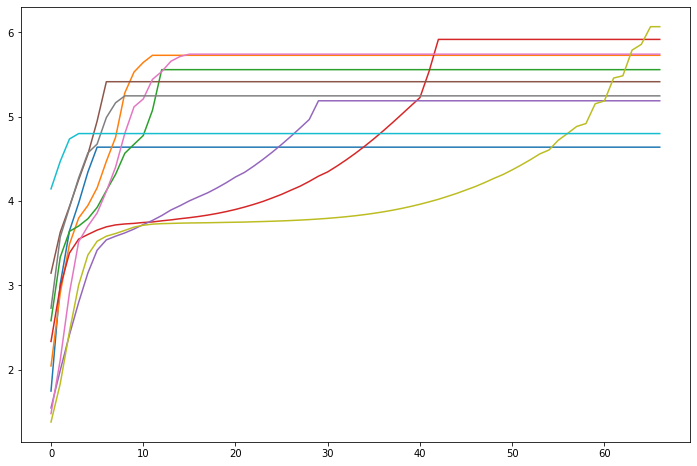

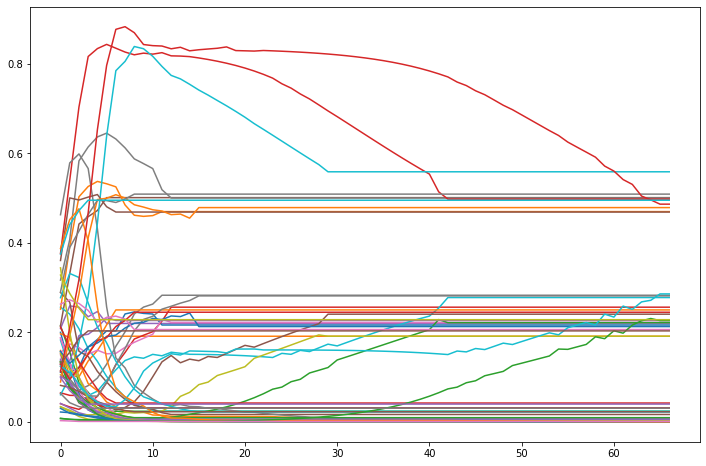

In [ ]:
fit_func_hist_cumulated = []
assets_history_cumulated = []

def hill_clibming_best_accept(start_state, step_size, reduce_step_size, n):
    ''' Function implementing Local search algorithm with best accept approach
        Input: 1D array, with n scalars inside, random numbers, sum is 1,
               float - initial size of step, (0.1 default)
               float - constant for reducing a step, should be sth (1,2> 
               int - number of assets in a portfolio (6 default)
        Output: 1D array, which Fitness function is better ~'''
    
    end = False
    present_state = start_state[:] # be careful to not making a reference instead of copy
    next_state = start_state[:]

    cnt = 0
    fitness_func_history = []
    
    assets_history = []
    while(not end):
        # print(step_size, fitness_function(present_state), present_state)
        end = True
        for i in range(n):
            for j in range(n-1):
                if i == j:
                    j += 1
                next_state[i] = present_state[i]*(1 + step_size)
                next_state[j] = present_state[j]*(1 - step_size)
                normalize_sample(next_state)
                # print(fitness_function(present_state), fitness_function(next_state))
                if fitness_function(next_state) > fitness_function(present_state):
                    end = False
                    present_state = next_state[:]
        fitness_func_history.append(fitness_function(present_state))
        assets_history.append(present_state)
        cnt += 1
        if cnt > 100:
            end = True
        step_size = step_size/reduce_step_size
    print('top:', fitness_function(present_state), present_state, 'final stepsize:', step_size, 'number of steps', cnt)
    ## for ploting
    fit_func_hist_cumulated.append(fitness_func_history)
    assets_history_cumulated.append(assets_history)


for i in range(10):
    hill_clibming_best_accept(random_sample_generator(6), 0.1, 1.01, number_of_assets)

fulfill_2d_list_for_plot(fit_func_hist_cumulated)
plot_multiple_samples(fit_func_hist_cumulated)
plt.show()

fulfill_2d_list_for_plot(assets_history_cumulated)
plot_multiple_samples(assets_history_cumulated)
plt.show()


Soo in *best accept* approach with the same parameters as in *first accept* we get far better results in less steps, we can adjust the parameters a bit to have more smaller steps.

But we are remaining stuck in the local minimums. Let's move on to simulated annealing.

Let s define a get_neighbor function wich allows us to have a quick access to all the neighbors of a current_state

In [ ]:
##Returns numbers_assets*numbers_assets-1 neighbors 

def get_neighbors(start_state,step_size):
    present_state = start_state[:]
    neighbor_state = start_state[:]
    neighbors = [start_state] 
    n = [ [] for i in range(len(start_state)*(len(start_state)-1))]
    k = 0
    for i in range(len(start_state)):
            for j in range(len(start_state)-1):
                if i == j:
                    j += 1
                neighbor_state[i] = present_state[i]*(1 + step_size)
                neighbor_state[j] = present_state[j]*(1 - step_size)
                normalize_sample(neighbor_state)
                present_state = neighbor_state
                n[k].extend(neighbor_state)
                k+=1
    
    return n


    

Simulated annealing :
 

top: 0.9664809474664016 [0.9999999956069077, 2.1674559915581633e-12, 7.244043119540546e-15, 1.9716193434322382e-18, 2.8160039411781974e-21, 4.3909176155884275e-09] final stepsize: 0.010207966465226955 number of steps 300
top: 0.9664809439547305 [0.9999999999999187, 1.194873550985852e-15, 2.3884157133462432e-21, 1.6884349167377972e-23, 5.067904129829228e-28, 8.000945526342403e-14] final stepsize: 0.010207966465226955 number of steps 300
top: 0.9664809440672248 [0.9999999998592146, 5.4112650048261095e-14, 4.016434221448519e-16, 1.634699479491217e-20, 1.1725640188798855e-23, 1.4073087730525242e-10] final stepsize: 0.010207966465226955 number of steps 300
top: 3.529139298311968 [0.019499831983969897, 9.676507757540485e-05, 9.312315420546632e-06, 1.4489265896068532e-06, 2.3412046959345539e-07, 0.9803924075759749] final stepsize: 0.010207966465226955 number of steps 300
top: 0.9665091437498806 [0.9999647483698252, 1.6877119164725205e-10, 2.6289452093205614e-11, 6.267106087315525e-14, 4.01063

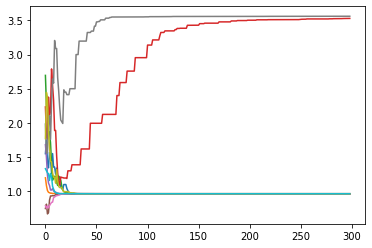

In [ ]:
def simulated_annealing(start_state,step_size, reduce_step_size,L,TO,alpha):

#declaration

    schedule = [1]*L
    for k in range(L-1):
        schedule[k] = TO*pow(alpha,k) # with 0,8<= alpha <= 0,9
    # present_state = start_state[:] # be careful to not making a reference instead of copy
    solution = start_state[:]
    fitness_func_history = []
    delta_E = 0

#Algo

    for k in range (L-1):
        neighbor = random.choice(get_neighbors(solution,step_size))

        # Check if neighbor is best so far
        delta_E = fitness_function(neighbor) - fitness_function(solution)

        # if the new solution is better, accept it
        if delta_E > 0 or random.random() <= exp(delta_E /schedule[k]):
            solution = neighbor[:]
        
        fitness_func_history.append(fitness_function(solution))
        step_size = step_size/reduce_step_size

    print('top:', fitness_function(solution), solution, 'final stepsize:', step_size, 'number of steps', L)

    ## ploting
    plt.plot(np.arange(L-1), fitness_func_history)

for i in range(10):
    simulated_annealing(random_sample_generator(6), 0.2, 1.01, 300, 10, 0.8)
plt.show()
    #print(fitness_func_history)
    ## for ploting
    #plt.plot(np.arange(L), fitness_func_history)

#results = []  
#best_r = 0  
#for i in range(10):
#    results.append(simulated_annealing(random_sample_generator(6), 0.2, 1.01, 100,10,0.8))
#best_r= max(results)
#print(best_r) 
